In [1]:
%matplotlib inline
from pylab import *
from skimage.morphology import watershed
import scipy.ndimage as ndimage
from PIL import Image, ImagePalette

from torch.nn import functional as F
from torchvision.transforms import ToTensor, Normalize, Compose
import torch

import tifffile as tiff
import cv2
import random
from pathlib import Path

In [2]:
random.seed(42)
NUCLEI_PALETTE = ImagePalette.random()
random.seed()

In [3]:
rcParams['figure.figsize'] = 15, 15

In [4]:
from models.ternausnet2 import TernausNetV2

/home/vladimir/anaconda3/lib/python3.6/site-packages/torch/utils/cpp_extension.py:118: UserWarning: 

                               !! WARNING !!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Your compiler (c++) may be ABI-incompatible with PyTorch!
Please use a compiler that is ABI-compatible with GCC 4.9 and above.
See https://gcc.gnu.org/onlinedocs/libstdc++/manual/abi.html.

See https://gist.github.com/goldsborough/d466f43e8ffc948ff92de7486c5216d6
for instructions on how to install GCC 4.9 or higher.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

                              !! WARNING !!

  warnings.warn(ABI_INCOMPATIBILITY_WARNING.format(compiler))


In [5]:
def get_model(model_path):
    model = TernausNetV2(num_classes=2)
    state = torch.load('weights/deepglobe_buildings.pt')
    state = {key.replace('module.', '').replace('bn.', ''): value for key, value in state['model'].items()}

    model.load_state_dict(state)
    model.eval()

    if torch.cuda.is_available():
        model.cuda()
    return model

In [6]:
def pad(img, pad_size=32):
    """
    Load image from a given path and pad it on the sides, so that eash side is divisible by 32 (network requirement)
    if pad = True:
        returns image as numpy.array, tuple with padding in pixels as(x_min_pad, y_min_pad, x_max_pad, y_max_pad)
    else:
        returns image as numpy.array
    """

    if pad_size == 0:
        return img

    height, width = img.shape[:2]

    if height % pad_size == 0:
        y_min_pad = 0
        y_max_pad = 0
    else:
        y_pad = pad_size - height % pad_size
        y_min_pad = int(y_pad / 2)
        y_max_pad = y_pad - y_min_pad

    if width % pad_size == 0:
        x_min_pad = 0
        x_max_pad = 0
    else:
        x_pad = pad_size - width % pad_size
        x_min_pad = int(x_pad / 2)
        x_max_pad = x_pad - x_min_pad

    img = cv2.copyMakeBorder(img, y_min_pad, y_max_pad, x_min_pad, x_max_pad, cv2.BORDER_REFLECT_101)

    return img, (x_min_pad, y_min_pad, x_max_pad, y_max_pad)

In [7]:
def unpad(img, pads):
    """
    img: numpy array of the shape (height, width)
    pads: (x_min_pad, y_min_pad, x_max_pad, y_max_pad)
    @return padded image
    """
    (x_min_pad, y_min_pad, x_max_pad, y_max_pad) = pads
    height, width = img.shape[:2]

    return img[y_min_pad:height - y_max_pad, x_min_pad:width - x_max_pad]

In [8]:
def minmax(img):
    out = np.zeros_like(img).astype(np.float32)
    if img.sum() == 0:
        return bands

    for i in range(img.shape[2]):
        c = img[:, :, i].min()
        d = img[:, :, i].max()

        t = (img[:, :, i] - c) / (d - c)
        out[:, :, i] = t
    return out.astype(np.float32)

In [9]:
def load_image(file_name_rgb, file_name_tif):    
    rgb = tiff.imread(str(file_name_rgb))    
    rgb = minmax(rgb)    
    tf = tiff.imread(str(file_name_tif)).astype(np.float32) / (2**11 - 1)
    
    return np.concatenate([rgb, tf], axis=2) * (2**8 - 1)

In [10]:
def label_watershed(before, after, component_size=20):
    markers = ndimage.label(after)[0]

    labels = watershed(-before, markers, mask=before, connectivity=8)
    unique, counts = np.unique(labels, return_counts=True)

    for (k, v) in dict(zip(unique, counts)).items():
        if v < component_size:
            labels[labels == k] = 0
    return labels

In [11]:
model = get_model('weights/deepglobe_buildings.pt')

In [12]:
img_transform = Compose([
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406, 0, 0, 0, 0, 0, 0, 0, 0], 
              std=[0.229, 0.224, 0.225, 1, 1, 1, 1, 1, 1, 1, 1])
])

In [13]:
file_name_rgb = Path('img') / 'RGB-PanSharpen_AOI_4_Shanghai_img6917.tif'
file_name_tif = Path('img') / 'MUL-PanSharpen_AOI_4_Shanghai_img6917.tif'

In [14]:
img = load_image(file_name_rgb, file_name_tif)

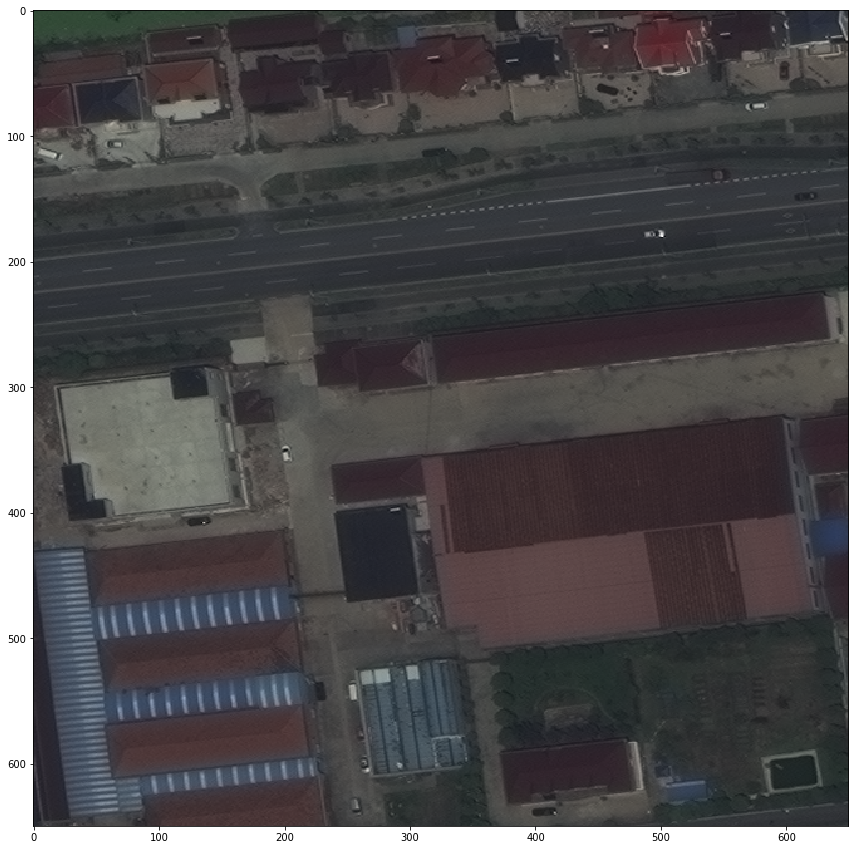

In [15]:
imshow(img[:, :, :3].astype(np.uint8))

In [16]:
# Network contains 5 maxpool layers => input should be divisible by 2**5 = 32 => we pad input image and mask
img, pads = pad(img)

In [17]:
input_img = torch.unsqueeze(img_transform(img / (2**8 - 1)).cuda(), dim=0)

In [18]:
prediction = torch.sigmoid(model(input_img)).data[0].cpu().numpy()

/home/vladimir/anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


In [19]:
# First predicted layer - mask
# Second predicted layer - touching areas
prediction.shape

(2, 672, 672)

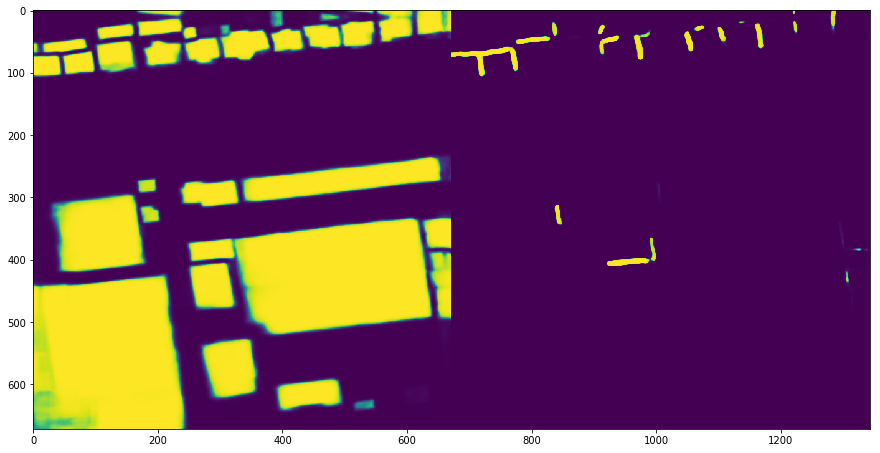

In [20]:
# left mask, right touching areas
imshow(np.hstack([prediction[0], prediction[1]]))

In [21]:
mask = (prediction[0] > 0.5).astype(np.uint8)
contour = (prediction[1])

seed = ((mask * (1 - contour)) > 0.5).astype(np.uint8)

In [22]:
labels = label_watershed(mask, seed)

In [23]:
labels = unpad(labels, pads)

In [24]:
im = Image.fromarray(labels.astype(np.uint8), mode='P')
im.putpalette(NUCLEI_PALETTE)

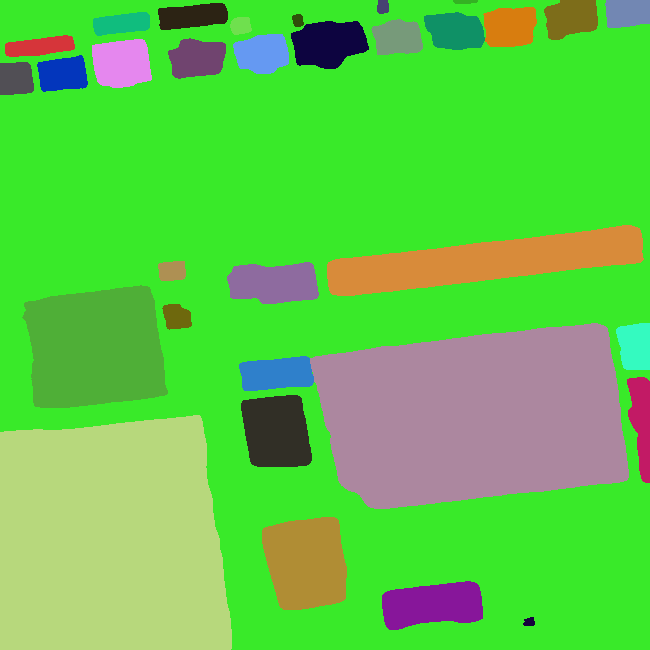

In [25]:
im